In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Datasets dan Dataloader

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
bs = 64
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)


# Arsitekstur dan Config

In [10]:
from jcopdl.layers import linear_block

In [13]:
class AutoEnconder(nn.Module):
    def __init__(self, z_size):
        super().__init__()

        self.encode = nn.Sequential(
            linear_block(784, 512, batch_norm=True),
            linear_block(512, 256, batch_norm=True),
            linear_block(256, z_size, activation='sigmoid'),
        )

        self.decode = nn.Sequential(
            linear_block(z_size, 256, batch_norm=True),
            linear_block(256, 512, batch_norm=True),
            linear_block(512, 784, activation='sigmoid'),
        )
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [12]:
config = set_config({
    'z_size' : 32,
    'batch_size':bs
})

# Training Preparation -> MCOC

In [14]:
model = AutoEnconder(config.z_size)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/ae')

# Training

### Fiturnya adalah target

In [16]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device)
        output = model(feature) # feedforward
        loss = criterion(output, feature)
        if mode == "train":
            loss.backward() # backpropragation
            optimizer.step() # update weight
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Evaluate

In [27]:
feature, _ = next(iter(testloader))
feature = feature.view(-1, 784).to(device)

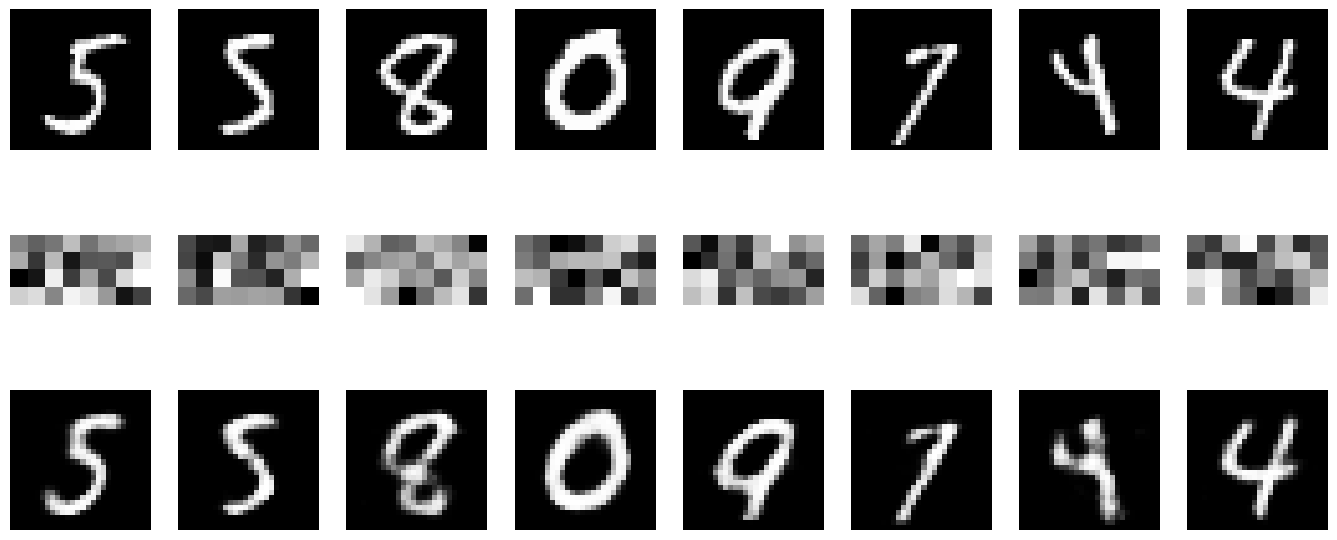

In [28]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))
for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')
    

# PlayGround

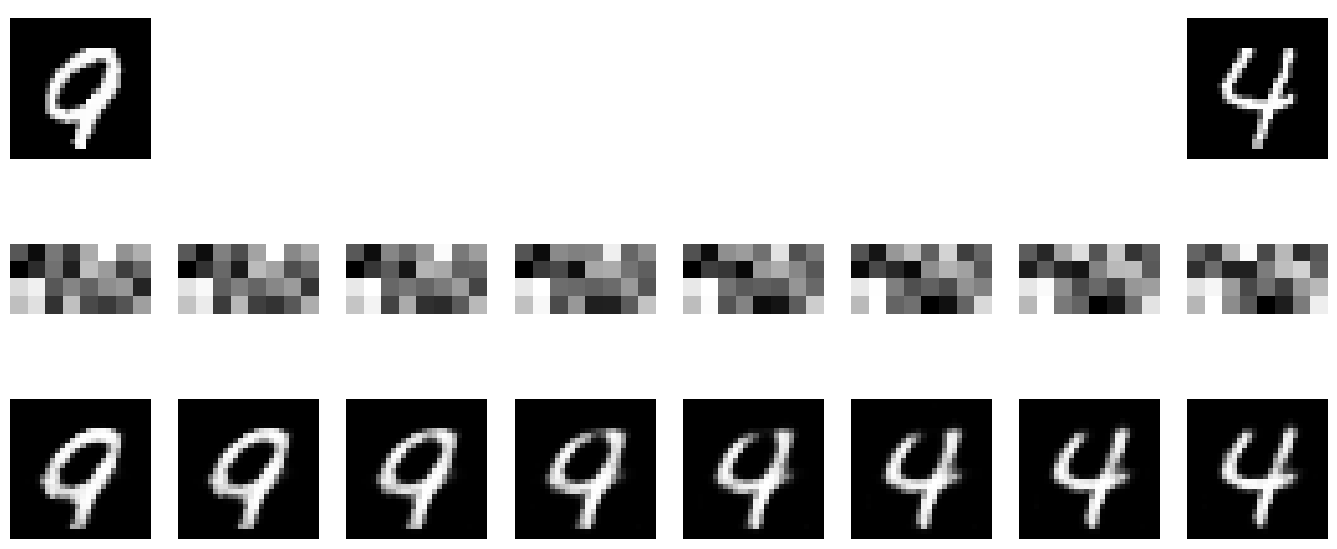

In [29]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    

    code1, code2 = enc[4], enc[7]
    codes = [(1-i)*code1 + i*code2 for i in np.linspace(0, 1, 8)]
    enc = torch.stack(codes)
    
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))
ax[0, 0].imshow(feature[4].view(28, 28).cpu(), cmap='gray')
ax[0, 7].imshow(feature[7].view(28, 28).cpu(), cmap='gray')

for i in range(8):
    # ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')
    

# Denoising AutoEncoder

In [34]:
def add_noise(images, noise_factor=0.5):
    images = torch.clone(images)
    images += noise_factor * torch.rand_like(images)
    images = images.clamp(0., 1.)
    return images

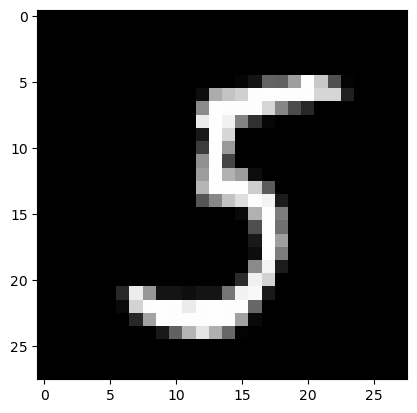

In [31]:
plt.imshow(feature[0].view(28,28).cpu(), cmap="gray")

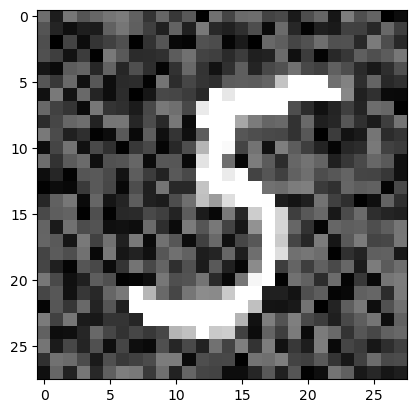

In [35]:
plt.imshow(add_noise(feature[0]).view(28,28).cpu(), cmap="gray")

# Training Preparation -> MCOC

In [36]:
model = AutoEnconder(config.z_size)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/dae')

# Training

### input atau fiturnya ditambah noise target tetap bersih

In [37]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device)
        output = model(add_noise(feature)) # feedforward
        loss = criterion(output, feature)
        if mode == "train":
            loss.backward() # backpropragation
            optimizer.step() # update weight
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3371 | Test_cost  = 0.2685 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1868 | Test_cost  = 0.1772 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1629 | Test_cost  = 0.1560 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1491 | Test_cost  = 0.1461 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1396 | Test_cost  = 0.1378 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1326 | Test_cost  = 0.1328 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1273 | Test_cost  = 0.1296 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1229 | Test_cost  = 0.1259 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1198 | Test_cost  = 0.1238 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1165 | Test_cost  = 0.1214 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1130 | Test_cost  = 0.1176 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1106 | Test_cost  = 0.1160 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1084 | Test_cost  = 0.1153 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1069 | Test_cost  = 0.1144 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1050 | Test_cost  = 0.1136 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1040 | Test_cost  = 0.1116 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1022 | Test_cost  = 0.1115 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1010 | Test_cost  = 0.1105 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0991 | Test_cost  = 0.1086 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0983 | Test_cost  = 0.1109 | 


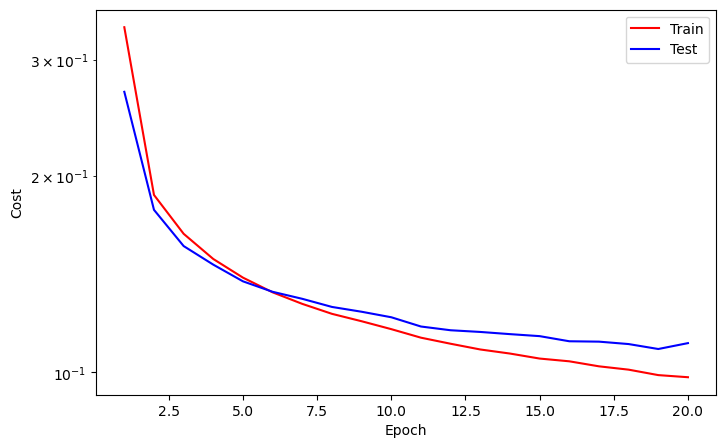

==> EarlyStop patience =  1 | Best test_cost: 0.1086


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0973 | Test_cost  = 0.1094 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1086


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0972 | Test_cost  = 0.1092 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1086


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0959 | Test_cost  = 0.1091 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1086


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0952 | Test_cost  = 0.1067 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0947 | Test_cost  = 0.1068 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1067


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0933 | Test_cost  = 0.1070 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1067


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0921 | Test_cost  = 0.1063 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0918 | Test_cost  = 0.1062 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0916 | Test_cost  = 0.1056 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0912 | Test_cost  = 0.1060 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1056


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0913 | Test_cost  = 0.1057 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1056


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0905 | Test_cost  = 0.1055 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0901 | Test_cost  = 0.1054 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0897 | Test_cost  = 0.1056 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1054


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0890 | Test_cost  = 0.1056 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1054


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0881 | Test_cost  = 0.1044 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0878 | Test_cost  = 0.1053 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1044


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0872 | Test_cost  = 0.1047 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1044


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0875 | Test_cost  = 0.1046 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1044


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0872 | Test_cost  = 0.1060 | 


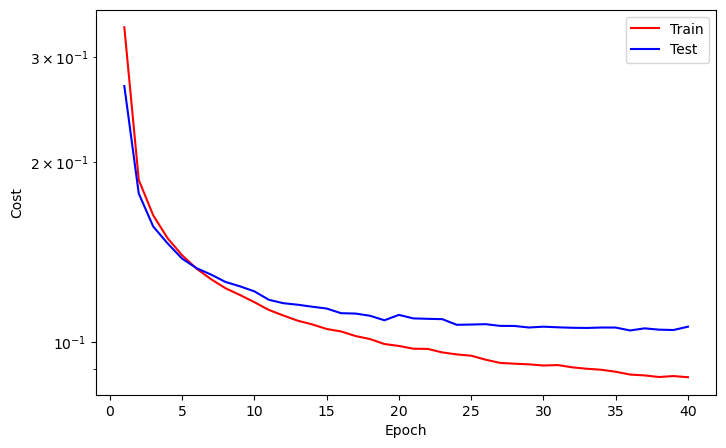

==> EarlyStop patience =  4 | Best test_cost: 0.1044


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0863 | Test_cost  = 0.1049 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1044
==> Execute Early Stopping at epoch: 41 | Best test_cost: 0.1044
==> Best model is saved at model/dae


/home/zaens/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/jcopdl/callback/_callback.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load

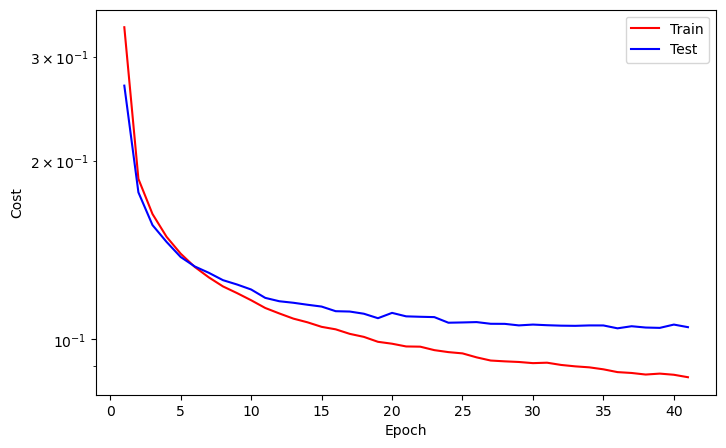

In [38]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Evaluate

In [41]:
feature, _ = next(iter(testloader))
feature = add_noise(feature).view(-1, 784).to(device)

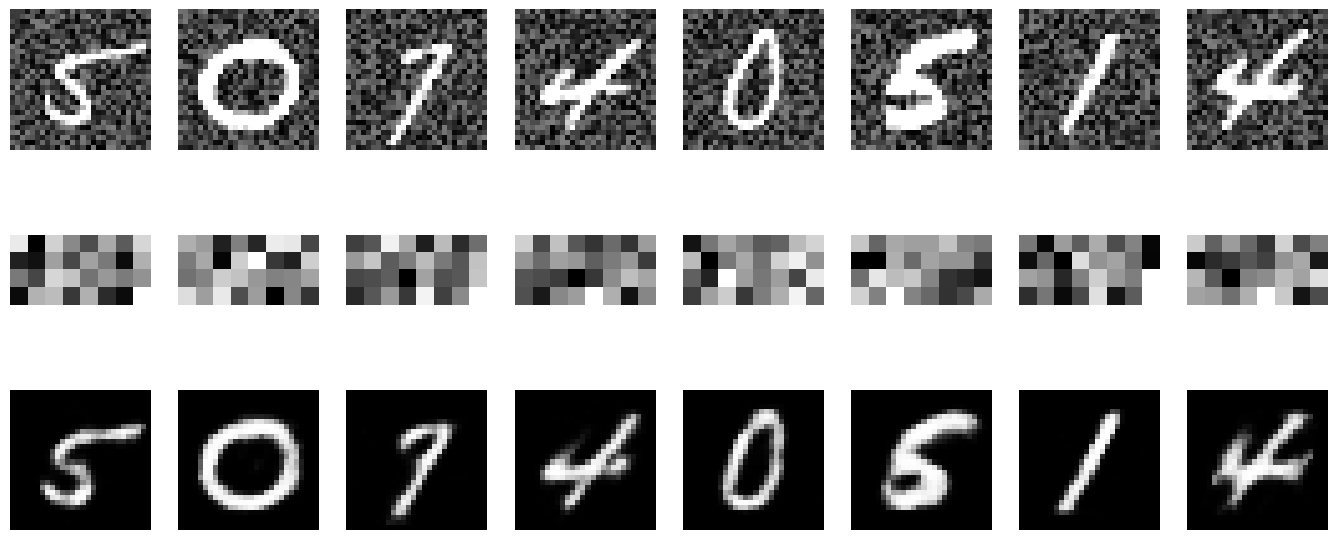

In [42]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))
for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')
    